In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import re
import string
from nltk.stem.porter import PorterStemmer # for text lemmantation
from keras.layers import TextVectorization, SimpleRNN, Input, Embedding, Dense, Bidirectional, LSTM, Dropout, GRU, Conv1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as api # for transfer learning
import math
import Transformer

2023-11-11 17:30:30.230084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 17:30:30.230114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 17:30:30.230132: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 17:30:30.235805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Processing

In [2]:
path = './dataset/fra.txt'

In [3]:
text_data = tf.data.TextLineDataset(path)

2023-11-11 17:30:34.252790: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-11-11 17:30:34.252813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 2lu-notebook
2023-11-11 17:30:34.252818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 2lu-notebook
2023-11-11 17:30:34.252859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.113.1
2023-11-11 17:30:34.252874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.113.1
2023-11-11 17:30:34.252878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.113.1


In [4]:
for i in text_data.take(1):
    print(i)

tf.Tensor(b'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)', shape=(), dtype=string)


In [5]:
for i in text_data.skip(227800):
    print(len(tf.strings.split(i, ' '))) # here we are trying to find the max length fo french and english
    # highest is 119 so heightest english and french is 60 almost

75
67
70
68
80
74
76
71
89
75
92
100
107
106
119


In [6]:
VOCAB_SIZE = 20000
ENGLISH_SEQUENCE_LEN=70
FRENCH_SEQUENCE_LEN = 70
EMBEDDING_DIM = 256
BATCH_SIZE=64
DENSE_DIM = 2048
NUM_HEADS = 8
NUM_LAYERS = 6

In [7]:
english_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LEN
)

In [8]:
french_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LEN
)

In [9]:
def selector(input_text):
    split_text = tf.strings.split(input_text, sep='\t')
    return {'input_1' : split_text[0:1], 'input_2': 'starttoken '+ split_text[1:2] + ' endtoken'}, split_text[1:2] + ' endtoken' # reason for start and end is written in rough copy

In [10]:
split_dataset = text_data.map(selector)

In [11]:
def selector(input_text):
    split_text = tf.strings.split(input_text, sep='\t')
    return split_text[0:1], 'starttoken '+ split_text[1:2] + ' endtoken'

In [12]:
init_dataset = text_data.map(selector)

In [13]:
for i in init_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va ! endtoken'], dtype=object)>)


In [14]:
for i in split_dataset.take(3):
    print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va ! endtoken'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche. endtoken'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route ! endtoken'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [15]:
english_training_dataset = init_dataset.map(lambda x,y:x)
english_vectorize_layer.adapt(english_training_dataset)

In [16]:
french_training_dataset = init_dataset.map(lambda x,y:y)
french_vectorize_layer.adapt(french_training_dataset)

In [17]:
def vectorizer(inputs, output):
    return {'input_1':english_vectorize_layer(inputs['input_1']),
            'input_2':french_vectorize_layer(inputs['input_2'])}, french_vectorize_layer(output)

In [18]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [19]:
dataset=split_dataset.map(vectorizer)

In [20]:
for i in dataset.take(10):
    print(i)

({'input_1': <tf.Tensor: shape=(1, 70), dtype=int64, numpy=
array([[44,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 70), dtype=int64, numpy=
array([[  2, 103,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 70), dtype=int64, numpy=
array([[103,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   

In [21]:
print(english_vectorize_layer.get_vocabulary()[44])
french_voc = french_vectorize_layer.get_vocabulary()
print(french_voc[2], french_voc[103], french_voc[3])

go
starttoken va endtoken


In [22]:
dataset = (dataset
           .shuffle(2048)
           .unbatch()
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE))

In [23]:
NUM_BATCHES = int(200000)/BATCH_SIZE

In [24]:
train_dataset = dataset.take(int(0.9*NUM_BATCHES))
val_dataset = dataset.skip(int(0.9*NUM_BATCHES))

In [25]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 70), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 70), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 70), dtype=tf.int64, name=None))>

# Modeling

In [30]:
NUM_UNITS = 256

In [31]:
### ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LEN), dtype='int64', name = 'input_1')
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(input)
encoded_input = Bidirectional(GRU(NUM_UNITS))(x)

## DECODER
shifted_target = Input(shape=(FRENCH_SEQUENCE_LEN), dtype='int64', name='input_2')
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(shifted_target)

x = GRU(NUM_UNITS*2, return_sequences=True)(x, initial_state=encoded_input) # return sequence=True means each step output is considered not just last step

## OUTPUT

x = Dropout(0.5)(x)
target = Dense(VOCAB_SIZE, activation='softmax')(x) # so each 70 sequence will generate 20,000 sized vector we pick best of each block
seq2seq_gru = Model([input, shifted_target], target)

seq2seq_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 70)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 70)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 70, 300)              6000000   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 70, 300)              6000000   ['input_2[0][0]']             
                                                                                              

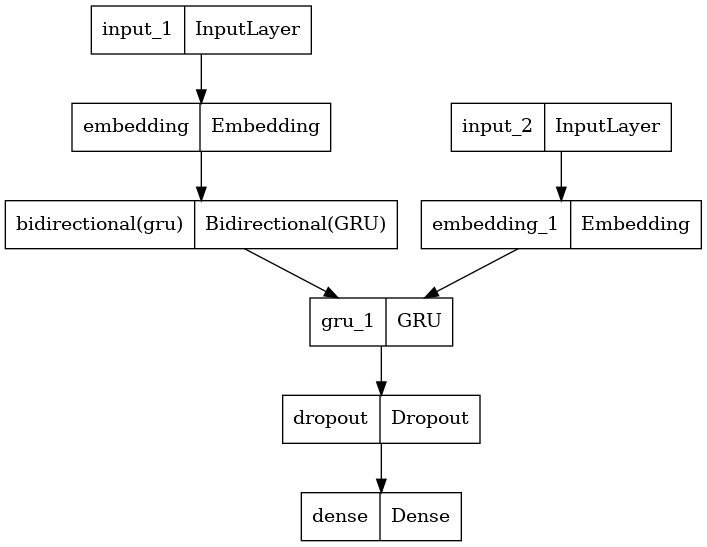

In [32]:
tf.keras.utils.plot_model(seq2seq_gru)

In [36]:
class BLEU(tf.keras.metrics.Metric):

  def __init__(self, name='bleu_score'):
    super(BLEU, self).__init__()
    self.bleu_score=0

  def update_state(self, y_true, y_pred, sample_weight=None):
    # here y_pred is in one hot encoding and y_true in bag of words
    y_pred = tf.argmax(y_pred, -1) # converting y_pred in bag of words
    self.bleu_score=0
    
    for i,j in zip(y_pred, y_true):
      tf.autograph.experimental.set_loop_options()
      total_pred_words = tf.math.count_nonzero(i)
      total_orig_words = tf.math.count_nonzero(j)
      total_matches = 0

      # brave_penalty = 1

      for word in i:
        if word==0:
          break
        for q in range(len(j)):
          if j[q]==0:
            break
          if j[q]==word:
            total_matches +=1
            j = tf.boolean_mask(j, [False if y==q else True for y in range(len(j))])
            break

      # if total_pred_words<=total_orig_words:
        # brave_penalty = math.exp(1-(total_orig_words/total_pred_words))

      self.bleu_score += total_matches/total_pred_words

  def result(self):
    return self.bleu_score/BATCH_SIZE

In [37]:
seq2seq_gru.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(1e-4),
    metrics=[BLEU()],
    run_eagerly=True
)

model_checkpoint_callback = ModelCheckpoint(
    './translator_gru.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [38]:
history =  seq2seq_gru.fit(train_dataset, epochs=15, validation_data=val_dataset, callbacks=[model_checkpoint_callback])

Epoch 1/15


2023-11-10 17:37:54.473776: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 341.80MiB (rounded to 358400000)requested by op Softmax
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-10 17:37:54.473849: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-11-10 17:37:54.473879: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 60, Chunks in use: 60. 15.0KiB allocated for chunks. 15.0KiB in use in bin. 365B client-requested in use in bin.
2023-11-10 17:37:54.473900: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-11-10 17:37:54.473922: I tensorflow/tsl/framework/bfc_allocator.cc:

ResourceExhaustedError: Exception encountered when calling layer 'dense' (type Dense).

{{function_node __wrapped__Softmax_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[64,70,20000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Softmax] name: 

Call arguments received by layer 'dense' (type Dense):
  • inputs=tf.Tensor(shape=(64, 70, 512), dtype=float32)

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate

In [ ]:
index_to_words = {x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                      french_vectorize_layer.get_vocabulary())}

In [ ]:
def translator(english_sentence):
    tokenized_english_sentence = english_vectorize_layer([english_sentence])
    shifted_target = 'starttoken'
    tokenzed_shifted_target = french_vectorize_layer([shifted_target])

    for i in range(FRENCH_SEQUENCE_LEN):
        output = seq2seq_gru.predict([tokenized_english_sentence, tokenzed_shifted_target])
        french_word_index = tf.argmax(output, axis=1)[0][1].numpy()

        current_word = index_to_words[french_word_index]

        if current_word=='endtoken':
            break
        shifted_target += ' ' + current_word

    french_sentence = shifted_target[11:] # to remove starttoken

    return french_sentence

# Attention

In [42]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units):
        super(Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.units = units
    
    def build(self, input_shape):
        self.embedding = Embedding(self.vocab_size, self.embedding_dim)
        self.lstm = LSTM(self.units, return_sequences=True)

    def call(self, x):
        x = self.embedding(x)
        output = self.lstm(x)
        return output

In [64]:
EMBEDDING_DIM = 25
HIDDEN_UNITS = 25
encoder = Encoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_UNITS)
encoder_output = encoder(tf.zeros([12, 7]))
encoder_output.shape

TensorShape([12, 7, 25])

In [41]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w_1 = Dense(self.units)
        self.w_2 = Dense(self.units)
        self.w = Dense(1)

    def call(self, prev_dec_state, enc_states):
        # op = self.w_2(enc_states)
        # print(op.shape)
        scores = self.w(
            self.w_1(tf.expand_dims(prev_dec_state, -2)) + 
            self.w_2(enc_states)
        )
        # print(scores.shape)

        attention_weights = tf.nn.softmax(scores, axis=1)
        context_vector = attention_weights*enc_states
        # print(context_vector.shape)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [51]:
bahdanau_attention = BahdanauAttention(150)
context_vector, attention_weights = bahdanau_attention(tf.zeros([128, 256]), tf.zeros([128, 70, 256]))
print(context_vector.shape)
print(attention_weights.shape)

(128, 256)
(128, 70, 1)


In [75]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, sequence_length):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.sequence_length = sequence_length

    def build(self, input_shape):
        self.dense = Dense(self.vocab_size, activation='softmax')
        self.gru = GRU(self.dec_units, return_sequences=True, return_state=True)
        self.attention = BahdanauAttention(self.dec_units)
        self.embedding = Embedding(self.vocab_size, self.embedding_dim)

    def call(self, x, hidden, shifted_target):
        outputs = []
        context_vectors = []
        attention_weightss = []
        shifted_target = self.embedding(shifted_target)
        # print(shifted_target.shape)

        for t in range(self.sequence_length):
            context_vector, attention_weights = self.attention(hidden, x)
            # print(context_vector.shape, shifted_target[:, t].shape)
            dec_input = context_vector+shifted_target[:, t]
            output, hidden = self.gru(tf.expand_dims(dec_input, 1))
            outputs.append(output[:, 0])

        outputs = tf.convert_to_tensor(outputs)
        outputs = tf.transpose(outputs, perm=[1, 0, 2])

        outputs = self.dense(outputs)
        return outputs, attention_weights

In [76]:
EMBEDDING_DIM = 25
HIDDEN_UNITS = 25
decoder = Decoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_UNITS, 7)
outputs, attention_weights = decoder(encoder_output, tf.zeros([12, HIDDEN_UNITS]), tf.zeros([12, 7]))
print(outputs.shape)
print(attention_weights.shape)

(12, 7, 20000)
(12, 7, 1)


In [82]:
# currently not working
EMBEDDING_DIM = 25
HIDDEN_UNITS = 25
ENGLISH_SEQUENCE_LEN = 7
FRENCH_SEQUENCE_LEN = 7

## ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LEN,), dtype='int64', name='input_1')
encoder = Encoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_UNITS)
encoder_output = encoder(input)

## DECODER
shifted_target = Input(shape=(FRENCH_SEQUENCE_LEN), dtype='int64', name='input_2')
decoder = Decoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_UNITS, FRENCH_SEQUENCE_LEN)
decoder_output = decoder(encoder_output, tf.zeros([1, HIDDEN_UNITS]), shifted_target)

## OUTPUT
bahdanau = Model([input, shifted_target, decoder_output])

bahdanau(tf.zeros(shape=(12, ENGLISH_SEQUENCE_LEN)))

NotImplementedError: Exception encountered when calling layer 'model_3' (type Model).

Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.

Call arguments received by layer 'model_3' (type Model):
  • inputs=tf.Tensor(shape=(12, 7), dtype=float32)
  • training=None
  • mask=None

# Transformer

In [26]:
WARM_UP_STEPS = 4000

In [27]:
lr_scheduler = Transformer.Scheduler(EMBEDDING_DIM, WARM_UP_STEPS)

In [29]:
transformer = Transformer.Transformer(ENGLISH_SEQUENCE_LEN, FRENCH_SEQUENCE_LEN, VOCAB_SIZE, EMBEDDING_DIM, DENSE_DIM, NUM_HEADS, NUM_LAYERS)

In [30]:
transformer.summary()

AttributeError: 'NoneType' object has no attribute 'summary'

In [37]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = Adam(lr_scheduler, beta_1=0.9, beta_2=0.98, epsilon=1e-9),)

In [38]:
history = transformer.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10


KeyboardInterrupt: 